In [39]:
# General imports
from multiprocessing import Pool
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import scipy.io

# Image processing imports
import cv2
import imutils
from imutils import face_utils
import dlib

# NN imports
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [150]:
'''
This function opens up the master lookup table and cleans the data (removing NaNs, Nones; Splitting into lists)
'''
def open_data(path):
    df1 = open(os.path.join(path), "r")  
    _list = df1.readlines()
    data = []
    for i in range(len(_list)):
        data.append(_list[i].split('\t'))
    df = pd.DataFrame(data)
    df.columns = df.iloc[0]
    df = df[1:]
    
    #remove rows without a gender
    df['gender'].replace('', np.nan, inplace=True)
    df['age'].replace('None', np.nan, inplace=True)
    df.dropna(subset=['gender'], inplace=True)
    df.dropna(subset=['age'], inplace=True)
    return df

In [151]:
'''
This function takes all the different age labels from the lookup table and changes it to categories.
Toddler:      0->3
Young_child:  4->6
Child:        7->14
Teenager:     15->20
Adolescent:   21->24
Young_adult:  25->32
Adult:        33->48 
Abraham:      49->59
Elderly:      60+

'''
def categorizing(df):
    categories = ['Toddler', 'Young_Child', 'Child', 'Teenager', 'Adolescent', 'Young_Adult', 'Adult', 'Abraham', 'Elderly']
    df['age'].replace(['(0, 2)', '2', '3'], categories[0], inplace = True)
    df['age'].replace(['(4, 6)'], categories[1], inplace = True)
    df['age'].replace(['(8, 12)', '13'], categories[2], inplace = True)
    df['age'].replace(['(15, 20)'], categories[3], inplace = True)
    df['age'].replace(['23', '22'], categories[4], inplace = True)
    df['age'].replace(['(27, 32)', '(25, 32)', '29'], categories[5], inplace = True)
    df['age'].replace(['35','34', '(38, 43)', '42', '46', '(38, 48)', '(38, 42)','45', '36'], categories[6], inplace = True)
    df['age'].replace(['(48, 53)','55', '58','57'], categories[7], inplace = True)
    df['age'].replace(['(60, 100)'], categories[8], inplace = True)
    df['age'].replace(['(8, 23)'], np.nan, inplace = True)
    df.dropna(subset=['age'], inplace=True)
    return df

In [152]:
df = open_data('C:/Users/Arno/Desktop/Facial/Final-Project-Bletchley-02/MasterText_fold_data.txt.txt')

In [153]:
df

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
1,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17\n
2,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94\n
3,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74\n
4,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47\n
5,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34\n
6,30601258@N03,11562582716_dbc2eb8002_o.jpg,1,"(25, 32)",f,0,422,1332,1498,-100,15,54\n
7,30601258@N03,10424595844_1009c687e4_o.jpg,4,"(38, 43)",f,1912,905,1224,1224,155,0,64\n
8,30601258@N03,9506931745_796300ca4a_o.jpg,5,"(25, 32)",f,1069,581,1575,1575,0,30,131\n
9,30601258@N03,10190308156_5c748ab2da_o.jpg,5,"(25, 32)",f,474,1893,485,484,-115,30,55\n
10,30601258@N03,10190308156_5c748ab2da_o.jpg,2,"(25, 32)",m,1013,1039,453,452,-75,0,59\n


In [154]:
df = categorizing(df)

In [155]:
# Make ID column to match with the pictures
df['ID'] = df['face_id']+'.'+df['original_image']

In [156]:
# Check data
count = df.groupby('age').nunique()
count

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score,ID
age,,,,,,,,,,,,,
Abraham,78,787,228,1,2,680,582,321,342,31,7,154,930
Adolescent,13,222,25,1,2,224,201,169,170,24,7,117,245
Adult,114,2352,462,1,2,1333,1040,608,646,38,7,187,2889
Child,66,1673,196,1,3,1167,998,506,507,37,7,178,2287
Elderly,65,728,185,1,3,618,528,297,312,36,7,150,867
Teenager,62,1069,316,1,3,1023,794,485,480,30,7,164,1642
Toddler,43,2499,55,1,3,1081,950,884,893,48,7,167,2509
Young_Adult,123,3812,623,1,3,1681,1236,792,876,38,7,190,5041
Young_Child,55,1962,130,1,3,1145,991,587,622,43,7,181,2140


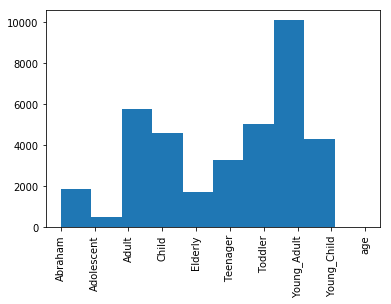

In [157]:
# Plot age distribution
plt.hist(df['age'])
plt.xticks(rotation=90)
plt.show()

In [158]:
'''
This function looks throught the folder and finds all the files with .jpg extension
'''
def find_files(folder_path, extension):
    directory = []
    for file in os.listdir(folder_path):
        if file.endswith(extension):
            directory.append(os.path.join(file))
    return directory

In [159]:
'''
This function should be used together with the find_files function. It will combine the face_id and the photo_id together
with the .jpg file extension to match the ID from the lookup dataframe.
'''
def get_ids(filename):
    ids = []
    for i in range(len(filename)):
        splits = filename[i].split('.')
        ids.append(splits[1]+'.'+splits[2]+'.jpg') # Face_id + original_image + .jpg
    df_ids = pd.DataFrame(ids)
    df_ids.rename(columns = {0: "ID"}, inplace=True)
    return df_ids

In [160]:
'''
This function overlaps the IDs from all the training pictures to the total dataset of pictures and extracts the data
from only the training data.
'''
def useful_df(look_up, subset):
    useful = look_up[look_up.ID.isin(subset['ID'])]
    useful.set_index('ID', inplace=True)
    useful['facial_landmarks'] = 0
    return useful    

In [161]:
def find_landmarks(image):
    landmarks_array = 0
    detector = dlib.get_frontal_face_detector()
    # Loading in the pretrained predictor
    predictor = dlib.shape_predictor('C:/Users/Arno/Desktop/Facial/shape_predictor_68_face_landmarks.dat')
    rects = detector(image,0)
    for (i, rect) in enumerate(rects):
        '''
        Determine the facial landmarks for the face region, then
        convert the facial landmark (x, y)-coordinates to a NumPy array
        '''
        face = predictor(image, rect)
        landmarks_array = face_utils.shape_to_np(face)
    return landmarks_array 

In [162]:
files = find_files('C:/Users/Arno/Desktop/Facial/DataBase', '.jpg')

In [163]:
files

['coarse_tilt_aligned_face.1000.8194283079_fe7c8c9b2f_o.jpg',
 'coarse_tilt_aligned_face.1000.8314899476_8c1ac2e4bb_o.jpg',
 'coarse_tilt_aligned_face.1000.8884658111_c692813a62_o.jpg',
 'coarse_tilt_aligned_face.1001.10009166853_a6b50b4117_o.jpg',
 'coarse_tilt_aligned_face.1001.8195375498_06c6fc5627_o.jpg',
 'coarse_tilt_aligned_face.1001.8215787552_3198c25285_o.jpg',
 'coarse_tilt_aligned_face.1001.8586120507_6c519d5923_o.jpg',
 'coarse_tilt_aligned_face.1002.8314893776_8ddb4d4549_o.jpg',
 'coarse_tilt_aligned_face.1003.8194283079_fe7c8c9b2f_o.jpg',
 'coarse_tilt_aligned_face.1004.8469357784_ac74572242_o.jpg',
 'coarse_tilt_aligned_face.1005.8313851951_3a0bd24aeb_o.jpg',
 'coarse_tilt_aligned_face.1005.8314901670_835a0aec49_o.jpg',
 'coarse_tilt_aligned_face.1006.11533025853_f3eb6ae6c7_o.jpg',
 'coarse_tilt_aligned_face.1050.11486219815_c7725c3300_o.jpg',
 'coarse_tilt_aligned_face.1050.11486520496_955dea5c71_o.jpg',
 'coarse_tilt_aligned_face.1050.11486644334_fcd534e0ec_o.jpg',
 'c

In [164]:
df_ids = get_ids(files)

In [165]:
# ID, Gender, Age of whole dataframe
df_IGA_only = df[['ID', 'gender', 'age']]

In [166]:
df_useful = useful_df(df_IGA_only,df_ids)

C:\Users\Arno\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [167]:
df_IGA_only[df_IGA_only.ID.isin(df_ids['ID'])]

,ID,gender,age
1912,132.11343916003_83b2d8d3e1_o.jpg,f,Young_Adult
1913,133.9345544977_d24ed0e29f_o.jpg,f,Adult
1914,132.11343848026_7f024ce9a7_o.jpg,f,Young_Adult
1915,134.11331383403_780c5e16b5_o.jpg,m,Abraham
1916,135.11345586926_27c45583a9_o.jpg,m,Abraham
1917,136.11345586926_27c45583a9_o.jpg,m,Abraham
1918,137.11345586926_27c45583a9_o.jpg,m,Abraham
1919,132.11343924233_0f17bf1461_o.jpg,f,Young_Adult
1920,138.9345522341_a6fa2675a6_o.jpg,f,Child
1921,139.11331412223_63218e1bc6_o.jpg,m,Adult


In [168]:
# Make array with every row: gender, age, facial landmarks
# This takes a long time! (+10min)
# tqdm makes progress bar
counter = 1 # Batch-counter starts at 1
for i in tqdm(range(len(files))):
    if i%100 == 0 and i!=0:  
        output_name = "training_set_%s.mat" %counter
        scipy.io.savemat(output_name, mdict={'out': test_data}, oned_as='row')
        counter +=1
        test_data = []
        
    # Last batch
    if i == len(files):
        output_name = "training_set_%s.mat" %counter
        scipy.io.savemat(output_name, mdict={'out': test_data}, oned_as='row')
        
        
    file = files[i]
    ID = get_ids([file]) # Get id from picture to match with dataframe, extra [] because input if def is a directory
    if ID['ID'][0] in df_useful.index:  # Check whether the ID is actually in the list
        image = cv2.imread(os.path.join('C:/Users/Arno/Desktop/Facial/DataBase',file),0) # 0 grayscales the image
        image = imutils.resize(image, width = 500) # Resize to 500 pixels        
        landmarks = find_landmarks(image)  # Get matrix of x,y coordinates of facial landmarks  
        information = df_useful.loc[ID['ID']].as_matrix()
        information = information[0] # Remove extra brackets imported when making directory
        information[2] = landmarks
        test_data.append(information)

  0%|                                                                                         | 0/6714 [00:00<?, ?it/s]


NameError: name 'test_data' is not defined

In [20]:
# Merge all the batches to one workable matrix
# Some batches were removed because they were empty

training_files = find_files('C:/Users/Arno/Desktop/Facial/Final-Project-Bletchley-02/Training', '.mat')
training_data = np.zeros(3) # Initiate
for file in training_files:
    print(file) # Check
    file_dir = 'C:/Users/Arno/Desktop/Facial/Final-Project-Bletchley-02/Training/'+file
    loading = scipy.io.loadmat(file_dir) # Put it in a variable, so it overwrites every iteration
    loading = loading['out']
    training_data = np.vstack((training_data, loading))

# Remove initial zero row
training_data = training_data[1:]

training_set_1.mat
training_set_10.mat
training_set_11.mat
training_set_12.mat
training_set_13.mat
training_set_14.mat
training_set_15.mat
training_set_16.mat
training_set_17.mat
training_set_18.mat
training_set_19.mat
training_set_2.mat
training_set_20.mat
training_set_21.mat
training_set_22.mat
training_set_23.mat
training_set_24.mat
training_set_25.mat
training_set_26.mat
training_set_27.mat
training_set_28.mat
training_set_29.mat
training_set_3.mat
training_set_30.mat
training_set_31.mat
training_set_32.mat
training_set_33.mat
training_set_34.mat
training_set_35.mat
training_set_36.mat
training_set_37.mat
training_set_38.mat
training_set_39.mat
training_set_4.mat
training_set_40.mat
training_set_41.mat
training_set_42.mat
training_set_43.mat
training_set_44.mat
training_set_45.mat
training_set_46.mat
training_set_47.mat
training_set_48.mat
training_set_49.mat
training_set_50.mat
training_set_51.mat
training_set_52.mat
training_set_53.mat
training_set_54.mat
training_set_55.mat
trai

In [21]:
# Clean the matrix of unidentified genders
df_clean = pd.DataFrame(training_data)
df_clean = df_clean[df_clean !=['u']]

# Clean the matrix of no facial landmarks (if no landmarks are found the program outputs [[0]], which has a length of 1)
df_clean = df_clean[df_clean[2].map(len) != 1]

df_clean.dropna(inplace=True)

C:\Users\Arno\Anaconda3\lib\site-packages\pandas\core\internals.py:1153: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = func(values, other)


In [22]:
# To numpy array again
training_data = df_clean.as_matrix()

In [23]:
# Splitting up the X_train and Y_train
Y_train = np.column_stack((training_data[:,0], training_data[:,1]))
X_train = training_data[:,2]

In [24]:
'''
Cleaning up the data. Scipy.io.loadmat puts every entry in its own formatted array. This loop removes all the entries and
puts it in one single array.
'''
for i in range(len(Y_train)):
    Y_train[i][0] = Y_train[i][0][0]
    Y_train[i][1] = Y_train[i][1][0]

In [25]:
'''Y_train still needs to be one hot encoded'''
df_Y_train = pd.DataFrame(Y_train)
Y_train_dummies = pd.get_dummies(df_Y_train).as_matrix()

In [26]:
'''
Splitting up into training and validation data
'''
# Validation size = 20% , rs=2 is seed
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train_dummies, test_size = 0.2, random_state = 4) 

# Split up the training outcome data into age and gender => Two different models
Y_train_gender = Y_train[:,0:2]
Y_train_age = Y_train[:,2:Y_train.shape[1]+1]
Y_val_gender = Y_val[:,0:2]
Y_val_age = Y_val[:,2:Y_train.shape[1]+1]

In [27]:
# Check if all have the same landmark length\n
def check_len(X_train):
    maxi = 0
    mini = 100
    for i in range(len(X_train)):
        if len(X_train[i]) > maxi:
            maxi = len(X_train[i])
        if len(X_train[i]) < mini:
            mini = len(X_train[i])
    print(mini, maxi)

In [28]:
check_len(X_train)

68 68


In [29]:
# Rework the shape of the numpy array\n",
def reshape(X_train):
    for i in range(1, len(X_train)):
        if i ==1:
            inter = np.concatenate((X_train[0], X_train[1]), axis=0)
        else:
            inter = np.concatenate((inter, X_train[i]), axis=0)
    inter = inter.reshape(len(X_train),68,2)
    return inter

In [30]:
X_train = reshape(X_train)
X_val = reshape(X_val)

In [31]:
X_train_input = X_train.reshape(len(X_train), 68*2)
X_val_input = X_val.reshape(len(X_val), 68*2)

In [140]:
'''
Building twe models: one for gender and one for age. Input is array with two columns, normal dense would suffice.
We also use dropout for robustness.
'''

# BASECASE 
model_gender_1 = Sequential()
model_gender_1.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_1.add(Dense(140))  
model_gender_1.add(Dense(100))
model_gender_1.add(Dense(50))
model_gender_1.add(Dense(10))
model_gender_1.add(Dense(2))
model_gender_1.add(Activation('sigmoid'))
model_gender_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# CHANGE RELU TO TANH IN FIRST TWO LAYERS
model_gender_2 = Sequential()
model_gender_2.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_2.add(Dense(140))  
model_gender_2.add(Dense(100))
model_gender_2.add(Dense(50))
model_gender_2.add(Dense(10))
model_gender_2.add(Dense(2))
model_gender_2.add(Activation('sigmoid'))
model_gender_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# BASECASE + DROPOUT
model_gender_3 = Sequential()
model_gender_3.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_3.add(Dense(140))  
model_gender_3.add(Dropout(0.2))
model_gender_3.add(Dense(100))
model_gender_3.add(Dense(50))
model_gender_3.add(Dense(10))
model_gender_3.add(Dense(2))
model_gender_3.add(Activation('sigmoid'))
model_gender_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# INCREASED SIZE OF DROPOUT
model_gender_4 = Sequential()
model_gender_4.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_4.add(Dense(140))  
model_gender_4.add(Dropout(0.4))
model_gender_4.add(Dense(100))
model_gender_4.add(Dense(50))
model_gender_4.add(Dense(10))
model_gender_4.add(Dense(2))
model_gender_4.add(Activation('sigmoid'))
model_gender_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# COMBINE TANH AND SMALLER DROPOUT
model_gender_5 = Sequential()
model_gender_5.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_5.add(Dense(140))  
model_gender_5.add(Dropout(0.2))
model_gender_5.add(Dense(100))
model_gender_5.add(Dense(50))
model_gender_5.add(Dense(10))
model_gender_5.add(Dense(2))
model_gender_5.add(Activation('sigmoid'))
model_gender_5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# NN Tanh, No dropout
model_gender_6 = Sequential()
model_gender_6.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_6.add(Dense(34))  
model_gender_6.add(Dense(10))
model_gender_6.add(Dense(2))
model_gender_6.add(Activation('sigmoid'))
model_gender_6.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# NN Tanh, With dropout
model_gender_7 = Sequential()
model_gender_7.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_7.add(Dense(34)) 
model_gender_7.add(Dropout(0.2))
model_gender_7.add(Dense(10))
model_gender_7.add(Dense(2))
model_gender_7.add(Activation('sigmoid'))
model_gender_7.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# NN Tanh, With dropout shifted to first layer
model_gender_8 = Sequential()
model_gender_8.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_gender_8.add(Dropout(0.2))
model_gender_8.add(Dense(34)) 
model_gender_8.add(Dense(10))
model_gender_8.add(Dense(2))
model_gender_8.add(Activation('sigmoid'))
model_gender_8.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




In [141]:
# BASECASE
model_age_1 = Sequential()
model_age_1.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_age_1.add(Dense(140))  
model_age_1.add(Dense(100))
model_age_1.add(Dense(50))
model_age_1.add(Dense(10))
model_age_1.add(Dense(8))
model_age_1.add(Activation('softmax'))
model_age_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Binary Crossemtropy
model_age_2 = Sequential()
model_age_2.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_age_2.add(Dense(140))  
model_age_2.add(Dense(100))
model_age_2.add(Dense(50))
model_age_2.add(Dense(10))
model_age_2.add(Dense(8))
model_age_2.add(Activation('softmax'))
model_age_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# ADD TANH TO FIRST TWO LAYERS
model_age_3 = Sequential()
model_age_3.add(Dense(68, input_shape=(X_train_input.shape[1:])))  # Amount of landmarks is 68
model_age_3.add(Dense(140))  
model_age_3.add(Dense(100))
model_age_3.add(Dense(50))
model_age_3.add(Dense(10))
model_age_3.add(Dense(8))
model_age_3.add(Activation('softmax'))
model_age_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [170]:
model_gender_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_450 (Dense)            (None, 68)                9316      
_________________________________________________________________
dense_451 (Dense)            (None, 140)               9660      
_________________________________________________________________
dense_452 (Dense)            (None, 100)               14100     
_________________________________________________________________
dense_453 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_454 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_455 (Dense)            (None, 2)                 22        
_________________________________________________________________
activation_416 (Activation)  (None, 2)                 0         
Total para

In [169]:
model_age_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_492 (Dense)            (None, 68)                9316      
_________________________________________________________________
dense_493 (Dense)            (None, 140)               9660      
_________________________________________________________________
dense_494 (Dense)            (None, 100)               14100     
_________________________________________________________________
dense_495 (Dense)            (None, 50)                5050      
_________________________________________________________________
dense_496 (Dense)            (None, 10)                510       
_________________________________________________________________
dense_497 (Dense)            (None, 8)                 88        
_________________________________________________________________
activation_443 (Activation)  (None, 8)                 0         
Total para

In [ ]:
model_gender_1.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_gender_2.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_gender_3.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_gender_4.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_gender_5.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_gender_6.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_gender_7.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_gender_8.fit(X_train_input, Y_train_gender, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_gender))

In [ ]:
model_age_1.fit(X_train_input, Y_train_age, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_age))

In [ ]:
model_age_2.fit(X_train_input, Y_train_age, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_age))

In [ ]:
model_age_3.fit(X_train_input, Y_train_age, epochs=10, batch_size=100, validation_data=(X_val_input, Y_val_age))

In [137]:
prediction = model_age_1.predict(X_train_input)

In [138]:
df_prediction = pd.DataFrame(prediction)

In [139]:
df_prediction

,0,1,2,3,4,5,6,7
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
pd.DataFrame(Y_train_age)

,0,1,2,3,4,5,6,7
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0
9,0,0,0,0,0,1,0,0
